# Multidimensional Scaling as Manifold Learning

Manifold Learning is a dimensionality reduction technique used to uncover and preserve the intrinsic low-dimensional structures embedded within high-dimensional data. 

It enables the extraction of meaningful structures and patterns from complex, high-dimensional datasets, facilitating improved data visualization, interpretation, and subsequent analysis.

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib.image import imread

## Multidimensional Scaling

Multidimensional Scaling (MDS) is a statistical technique that reduces high-dimensional data by preserving the pairwise distances between points in a lower-dimensional space. It is a type of manifold learning technique.

Let's start by generating some two-dimensional data that we can use to define a manifold.

In [2]:
def get_GOLIATH(N=1000, seed=42):
    '''
    Open Goliath.PNG and draw random points from it.
    '''
    data = imread('Goliath.png')[::-1, :, 0].T
    rng = np.random.RandomState(seed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

In [3]:
# Generate data points
df = pd.DataFrame(get_GOLIATH(1000), columns=['x0', 'x1'])
print(df.shape)
df.head()

(1000, 2)


,x0,x1
0,0.054973,0.511780
1,0.055191,0.542015
2,0.079438,0.476843
3,0.082999,0.586602
4,0.083407,0.322079


In [4]:
# Creating labels for plotting
def add_labels(df):
    '''
    Adding labels to the data points for plotting
    '''
    differences = np.diff(df.x0)
    large_gaps = differences > 0.08
    # Labels will be letters in alphabet
    alphabet = 'GOLIATH'
    labels = np.zeros_like(df.x0, dtype='<U1')
    label_index = 0
    for i, gap in enumerate(large_gaps):
        labels[i] = alphabet[label_index % len(alphabet)]
        if gap:
            label_index += 1
    labels[-1] = alphabet[label_index % len(alphabet)]  # Label for the last element
    df['labels'] = labels
    return df

In [5]:
df = add_labels(df)
df.head()

,x0,x1,labels
0,0.054973,0.511780,G
1,0.055191,0.542015,G
2,0.079438,0.476843,G
3,0.082999,0.586602,G
4,0.083407,0.322079,G


In [6]:
def plot_GOLIATH(df):
    '''
    Plot the data in a two-dimensional scatterplot.
    '''    
    fig = px.scatter(df, x='x0', y='x1', color='labels', 
                     color_discrete_sequence=px.colors.qualitative.G10)       
    fig.update_layout(width=600, height=400, 
                      xaxis=dict(scaleanchor="y", scaleratio=1),
                      yaxis=dict(scaleanchor="x", scaleratio=1),
                      title='GOLIATH Scatterplot')     
    return fig

In [7]:
plot_GOLIATH(df)

In [8]:
def rotate(df, angle):
    '''
    It rotates the data points by the given angle.
    '''
    df_temp = df.copy()
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    df_temp[['x0', 'x1']] = np.dot(df_temp[['x0', 'x1']], R)
    return df_temp

In [9]:
# Rotate the data points by -20 degrees
df1 = rotate(df, -20)

# Plot the rotated data points
plot_GOLIATH(df1)

In [10]:
# Rotate the data points by 50 degrees
df2 = rotate(df, 50)

plot_GOLIATH(df2)

The previous examples tell us that the `x` and `y` values are not necessarily fundamental to the relationships in the data.

In this case, the distance between each point and the other points in the dataset is crucial.

A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.

Let's use Scikit-Learn's `pairwise_distances` function for our original data.

In [11]:
from sklearn.metrics import pairwise_distances

In [12]:
# Compute the pairwise distances between the data points
D  = pairwise_distances(df[['x0', 'x1']])
D1 = pairwise_distances(df1[['x0', 'x1']])
D2 = pairwise_distances(df2[['x0', 'x1']])

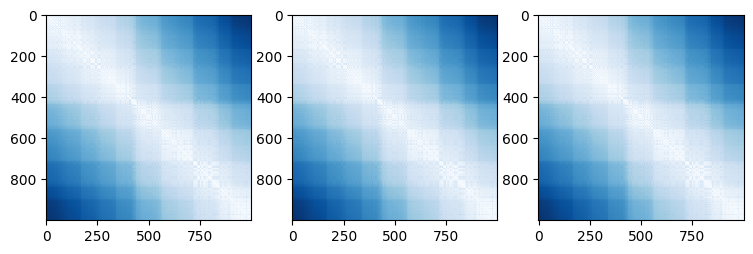

In [13]:
# Plot the distance matrices
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')

plt.subplot(132)
plt.imshow(D1, zorder=2, cmap='Blues', interpolation='nearest')

plt.subplot(133)
plt.imshow(D2, zorder=2, cmap='Blues', interpolation='nearest');

This distance matrix represents the data invariant to rotations and translations. You can see it is the same for all the three pairwise distances computed.

What the MDS algorithm does is, given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.

In [14]:
from sklearn.manifold import MDS

In [15]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=9, normalized_stress='auto')
df1[['x0','x1']] = model.fit_transform(D)

plot_GOLIATH(df1)

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

We set a value for `random_state=1` for reproducibility: every time you run the MDS with the same input data and the same value for `random_state`, you will get the same output configuration.

Changing the `random_state` value might result in different final embeddings, but notice that MDS preserves the pairwise distances between points.

In [16]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=5, normalized_stress='auto')
df2[['x0','x1']] = model.fit_transform(D)

plot_GOLIATH(df2)

### Analysis in 3-dimensions: GOLIATH

Instead of rotating the data in the two-dimensional plane, we can project it into three dimensions, compute the distance matrix, and use MDS to determine the optimal two-dimensional embedding for this distance matrix.

In [17]:
def random_projection(df, n=3, random_state=42):
    '''
    Random projection of the points in DataFrame 'df' to an 'n'-dimensional space.
    '''
    labels = df.labels
    df = df.drop('labels', axis=1)
    assert n >= df.shape[1]
    rng = np.random.RandomState(random_state)
    C = rng.randn(n, n)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    projected_data = np.dot(df.values, V[:df.shape[1]])
    # Converting the resulting array back to a DataFrame
    df = pd.DataFrame(projected_data, index=df.index, 
                      columns=[f'x{i}' for i in range(projected_data.shape[1])])
    df['labels'] = labels
    return df

In [18]:
df3D = random_projection(df, 3)
df3D.head()

,x0,x1,x2,labels
0,0.296820,0.254914,0.334452,G
1,0.316275,0.267673,0.353762,G
2,0.258679,0.258941,0.315793,G
3,0.327550,0.307361,0.386304,G
4,0.155871,0.197492,0.217699,G


In [19]:
print('Original data shape:  ', df.shape)
print('Projected data shape: ', df3D.shape)

Original data shape:   (1000, 3)
Projected data shape:  (1000, 4)


Let's visualize these points to see what we're working with.

In [20]:
# Plot the 3D data points
fig = px.scatter_3d(df3D, x='x0', y='x1', z='x2', color='labels',
                    color_discrete_sequence=px.colors.qualitative.G10)
# Adjusting the view angle    
fig.update_layout(scene_camera=dict(eye=dict(x=1.2, y=1.2, z=0)),                      
                width=600, height=400, 
                title='GOLIATH - 3D Scatterplot') 
fig.show()

Remember, the graph is interactive, meaning you can zoom in, pan around, and get more information about data points just by hovering your mouse. The legend is also interactive, providing an exciting way to explore the data.

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.

In [21]:
model3 = MDS(n_components=2, random_state=28, normalized_stress='auto')
df3 = pd.DataFrame(model3.fit_transform(df3D[['x0', 'x1', 'x2']]), columns=['x0', 'x1'])
df3['labels'] = df3D.labels

plot_GOLIATH(df3)

In [22]:
# Modifying the random_state parameter
model4 = MDS(n_components=2, random_state=5, normalized_stress='auto')
df4 = pd.DataFrame(model4.fit_transform(df3D[['x0', 'x1', 'x2']]), columns=['x0', 'x1'])
df4['labels'] = df3D.labels

plot_GOLIATH(df4)

The example illustrates the purpose of a manifold learning estimator: given high-dimensional embedded data (`df3D`), it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, that relationship is the distance between every pair of points.

### Analysis in 3-dimensions: S-Shape GOLIATH

Previous discussion has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.

Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.

Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [23]:
def make_goliath_s_curve(df):
    '''
    Transform the DataFrame 'df' with columns 'x0', 'x1', 'x2' 
    into a new shape resembling the 'GOLIATH S-curve'.
    '''    
    t = (df.x0 - 2) * 0.78 * np.pi
    x = np.sin(t)
    y = df.x1 * 1.5
    z = np.sign(t) * (np.cos(t) - 1) * 1.5
    df_res = pd.DataFrame({'x0': x, 'x1': y, 'x2': z, 'labels': df.labels})
    return df_res

In [24]:
dfS = make_goliath_s_curve(df)
dfS.head()

,x0,x1,x2,labels
0,0.998554,0.767671,1.419358,G
1,0.998582,0.813023,1.420157,G
2,0.999981,0.715265,1.509244,G
3,0.999889,0.879903,1.522331,G
4,0.999874,0.483119,1.523832,G


In [25]:
# Saving the S-Shape GOLIATH points
dfS.to_csv('GOLIATH_S_curve.csv', index=False)

In [26]:
# Plot the 3D data points
figS = px.scatter_3d(dfS, x='x0', y='x1', z='x2', color='labels',
                     color_discrete_sequence=px.colors.qualitative.G10)
# Adjusting the view angle    
figS.update_layout(scene_camera=dict(eye=dict(x=1.1, y=1.1, z=1)),                    
                width=600, height=400, 
                title='S-Shape GOLIATH - 3D Scatterplot')                  
figS.show()

This is again three-dimensional data, but we can see that the embedding is much more complicated.

Remember, the graph is interactive, meaning you can zoom in, pan around, and get more information about data points just by hovering your mouse. 

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold.

In [27]:
modelS = MDS(n_components=2, random_state=19, normalized_stress='auto')
dfS1 = pd.DataFrame(modelS.fit_transform(dfS[['x0', 'x1', 'x2']]), columns=['x0', 'x1'])
dfS1['labels'] = df3D.labels

plot_GOLIATH(dfS1)

The best two-dimensional linear embedding does not unwrap the S-curve! The MDS for this case failed!

With the default option `metric=True`, the MDS class performs classical (metric) MDS, which is a linear approach.

If we set `metric=False`,  it performs non-metric MDS, which is a non-linear approach. Non-metric MDS aims to preserve the rank order of the dissimilarities rather than their actual values and usually involves an iterative process to find the best low-dimensional representation. That is not our case, but we could try it!

In [28]:
modelS = MDS(n_components=2, random_state=19, normalized_stress='auto', metric=False)
dfS2 = pd.DataFrame(modelS.fit_transform(dfS[['x0', 'x1', 'x2']]), columns=['x0', 'x1'])
dfS2['labels'] = df3D.labels

plot_GOLIATH(dfS2)

As expected, the MDS algorithm failed again!

## References

- https://scikit-learn.org/stable/modules/manifold.html
- Muller, A.C. & Guido, S. (2017) Introduction to Machine Learning with Python. A guide for Data scientists. USA: O'Reilly, chapter 3.
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O'Reilly Media, Inc. chapter 5.